In [1]:
from hossam import load_data
from pandas import DataFrame, get_dummies
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np

from scipy.stats import zscore, pearsonr, spearmanr
from itertools import combinations
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from sklearn.metrics import confusion_matrix,roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
my_dpi = 200                                    # 이미지 선명도(100~300)
font_path = "./NotoSansKR-Regular.ttf"          # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)               # 폰트의 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname=font_path)  # 폰트의 속성을 읽어옴
font_name = font_prop.get_name()                # 읽어온 속성에서 폰트의 이름만 추출     
plt.rcParams['font.family'] = font_name         # 그래프에 한글 폰트 적용
plt.rcParams['font.size'] = 10                  # 기본 폰트크기
plt.rcParams['axes.unicode_minus'] = False      # 그래프에 마이너스 깨짐 방지(한글환경에서 필수)

### 1단계.데이터와 첫인상-"이 데이터는 어떤 세계를 보여주고 있을까?"

In [3]:
origin = load_data('apple_quality')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n===== 타입확인 =====")
print(origin.info())

origin.head(10)

[data] https://data.hossam.kr/data/kaggle/apple_quality.xlsx
[desc] 이 데이터 세트는 다양한 과일 속성에 대한 정보를 담고 있어 과일의 특성을 파악하는 데 도움이 됩니다. 데이터 세트에는 과일 ID, 크기, 무게, 당도, 아삭함, 과즙량, 숙성도, 산도 및 품질과 같은 세부 정보가 포함되어 있습니다. (출처: https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality)

field        description
-----------  ----------------------------------
A_id         각 과일에 대한 고유 식별자
Size         크기
Weight       무게
Sweetness    단맛 정도
Crunchiness  과일의 아삭한 식감을 나타내는 질감
Juiciness    과일의 과즙 함량 정도
Ripeness     과일이 익은 정도
Acidity      과일의 산도 수준
Quality      과일의 전반적인 품질


===== 데이터 크기 확인 =====
데이터셋 크기: (4000, 9)
열 개수: 9
행 개수: 4000

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   int64  
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunc

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,good
1,1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,good
2,2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,bad
3,3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,good
4,4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,good
5,5,-3.425400,-1.409082,-1.913511,-0.555775,-3.853071,1.914616,-2.981523,bad
6,6,1.331606,1.635956,0.875974,-1.677798,3.106344,-1.847417,2.414171,good
7,7,-1.995462,-0.428958,1.530644,-0.742972,0.158834,0.974438,-1.470125,good
8,8,-3.867632,-3.734514,0.986429,-1.207655,2.292873,4.080921,-4.871905,bad
9,9,-0.727983,-0.442820,-4.092223,0.597513,0.393714,1.620857,2.185608,bad


In [4]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   int64  
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4000 non-null   float64
 8   Quality      4000 non-null   object 
dtypes: float64(7), int64(1), object(1)
memory usage: 281.4+ KB


1. 범주형은  A_id, Quality 로 확인하고 Quality가 중요하다고 예측한다.

### 2단계.목표 변수 시각화-"우리가 맞히려는 대상은 어떤 분포를 가지고 있을까?"

In [5]:
타입변경df= origin.astype({'Quality':'category'})
타입변경df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   A_id         4000 non-null   int64   
 1   Size         4000 non-null   float64 
 2   Weight       4000 non-null   float64 
 3   Sweetness    4000 non-null   float64 
 4   Crunchiness  4000 non-null   float64 
 5   Juiciness    4000 non-null   float64 
 6   Ripeness     4000 non-null   float64 
 7   Acidity      4000 non-null   float64 
 8   Quality      4000 non-null   category
dtypes: category(1), float64(7), int64(1)
memory usage: 254.2 KB


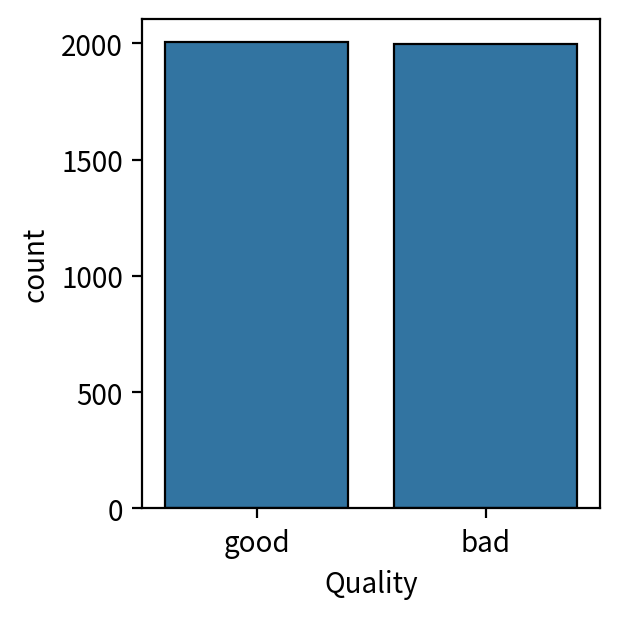

In [6]:
width_px = 640
height_px = 640
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi= my_dpi)

sb.countplot(x=origin['Quality'],  edgecolor="#000000", linewidth=0.8)


plt.tight_layout()
plt.show()
plt.close()

In [7]:
origin['Quality'].value_counts(normalize=True)


Quality
good    0.501
bad     0.499
Name: proportion, dtype: float64

막대그래프 또는 지표로 보았을때  불균형하지 않고 good과 bad가 0.501:0.499로 균형을 이루고 있다.

### 3단계.단변량EDA-"사과 하나만 놓고 보았을 때,무엇이 보일까?"

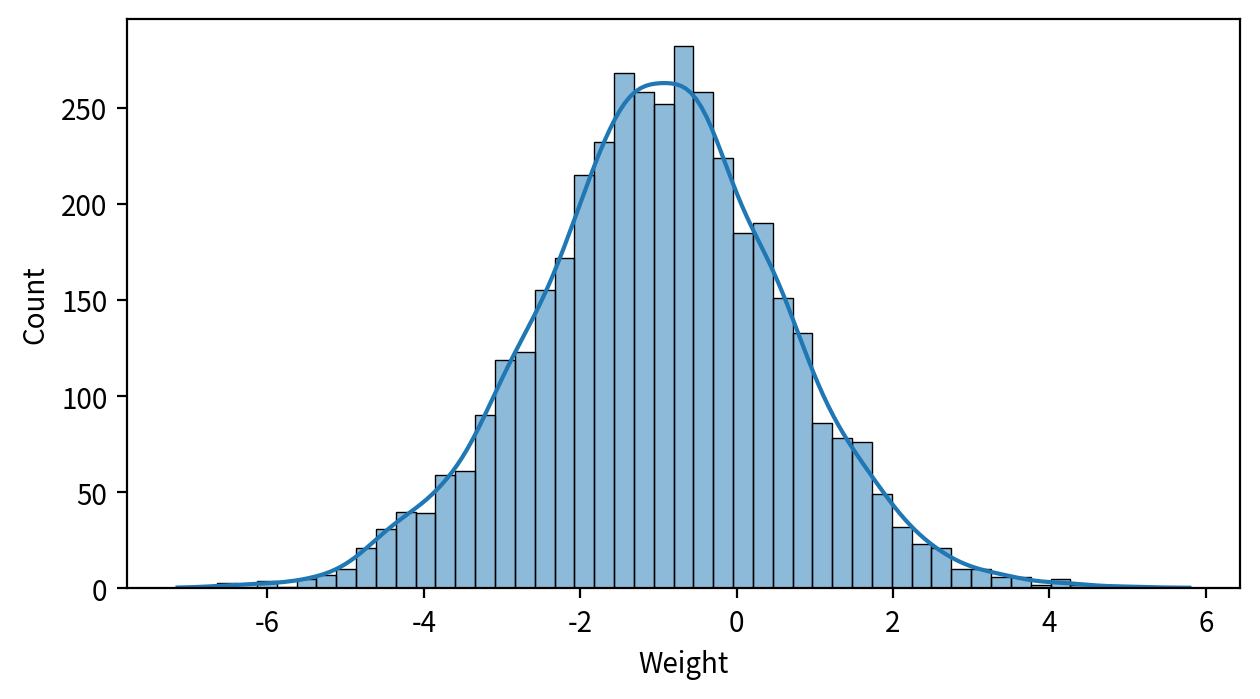

In [8]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.histplot(data=origin, x="Weight", edgecolor="#000000", 
            linewidth=0.5, kde=True)


plt.tight_layout()
plt.show()
plt.close()

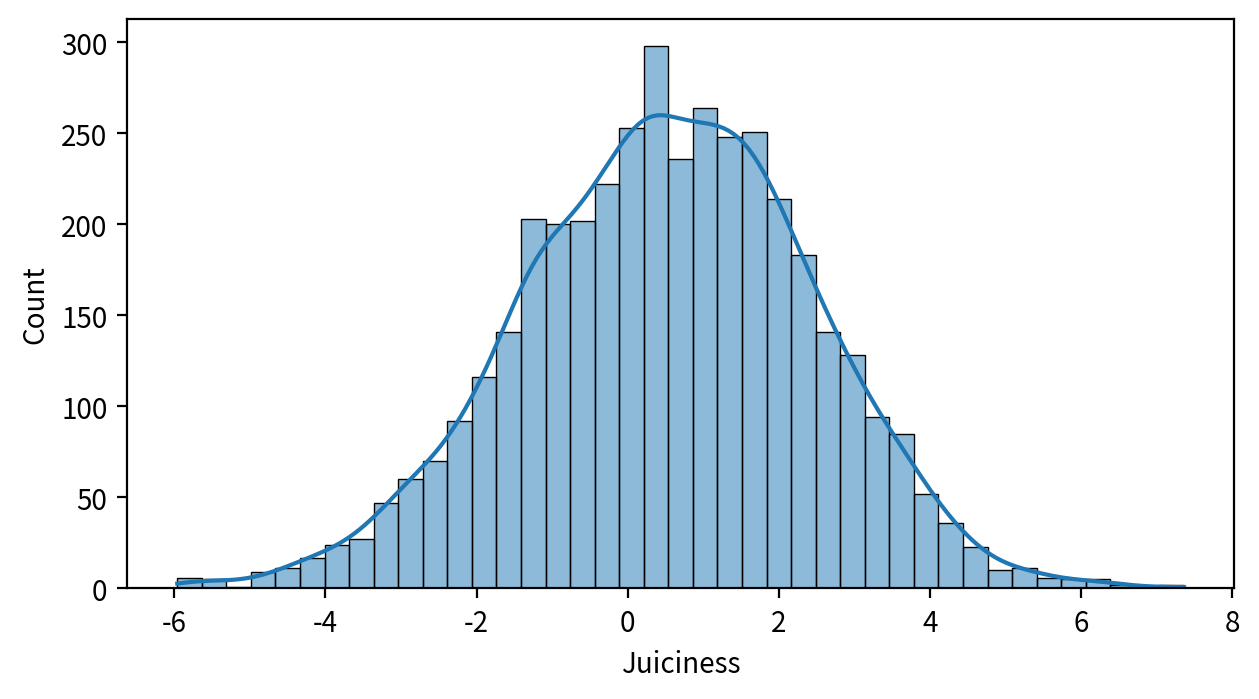

In [9]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.histplot(data=origin, x="Juiciness", edgecolor="#000000", 
            linewidth=0.5, kde=True)


plt.tight_layout()
plt.show()
plt.close()

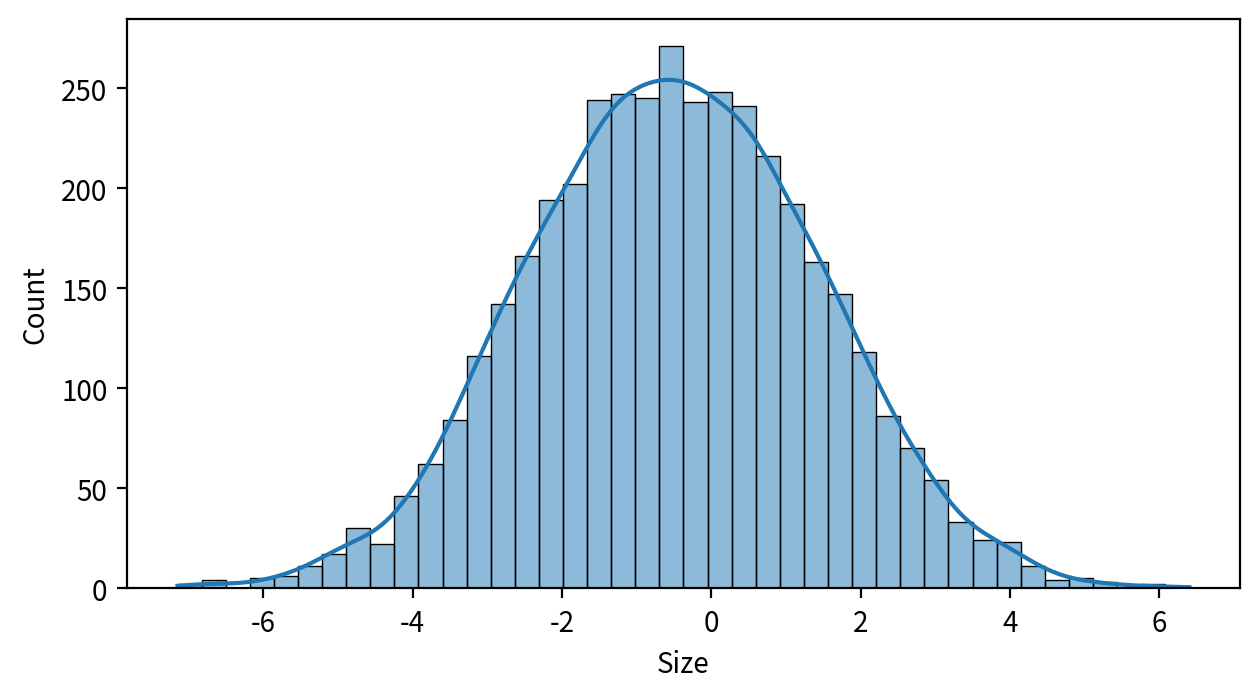

In [10]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.histplot(data=origin, x="Size", edgecolor="#000000", 
            linewidth=0.5, kde=True)


plt.tight_layout()
plt.show()
plt.close()

In [11]:
origin['Weight'].skew()

np.float64(0.003101570142725525)

In [12]:
origin.skew(numeric_only=True)


A_id           0.000000
Size          -0.002437
Weight         0.003102
Sweetness      0.083850
Crunchiness    0.000230
Juiciness     -0.113421
Ripeness      -0.008764
Acidity        0.055783
dtype: float64

In [13]:
origin.describe().T

,count,mean,std,min,25%,50%,75%,max
A_id,4000.0,1999.500000,1154.844867,0.000000,999.750000,1999.500000,2999.250000,3999.000000
Size,4000.0,-0.503015,1.928059,-7.151703,-1.816765,-0.513703,0.805526,6.406367
Weight,4000.0,-0.989547,1.602507,-7.149848,-2.011770,-0.984736,0.030976,5.790714
Sweetness,4000.0,-0.470479,1.943441,-6.894485,-1.738425,-0.504758,0.801922,6.374916
Crunchiness,4000.0,0.985478,1.402757,-6.055058,0.062764,0.998249,1.894234,7.619852
Juiciness,4000.0,0.512118,1.930286,-5.961897,-0.801286,0.534219,1.835976,7.364403
Ripeness,4000.0,0.498277,1.874427,-5.864599,-0.771677,0.503445,1.766212,7.237837
Acidity,4000.0,0.076877,2.110270,-7.010538,-1.377424,0.022609,1.510493,7.404736


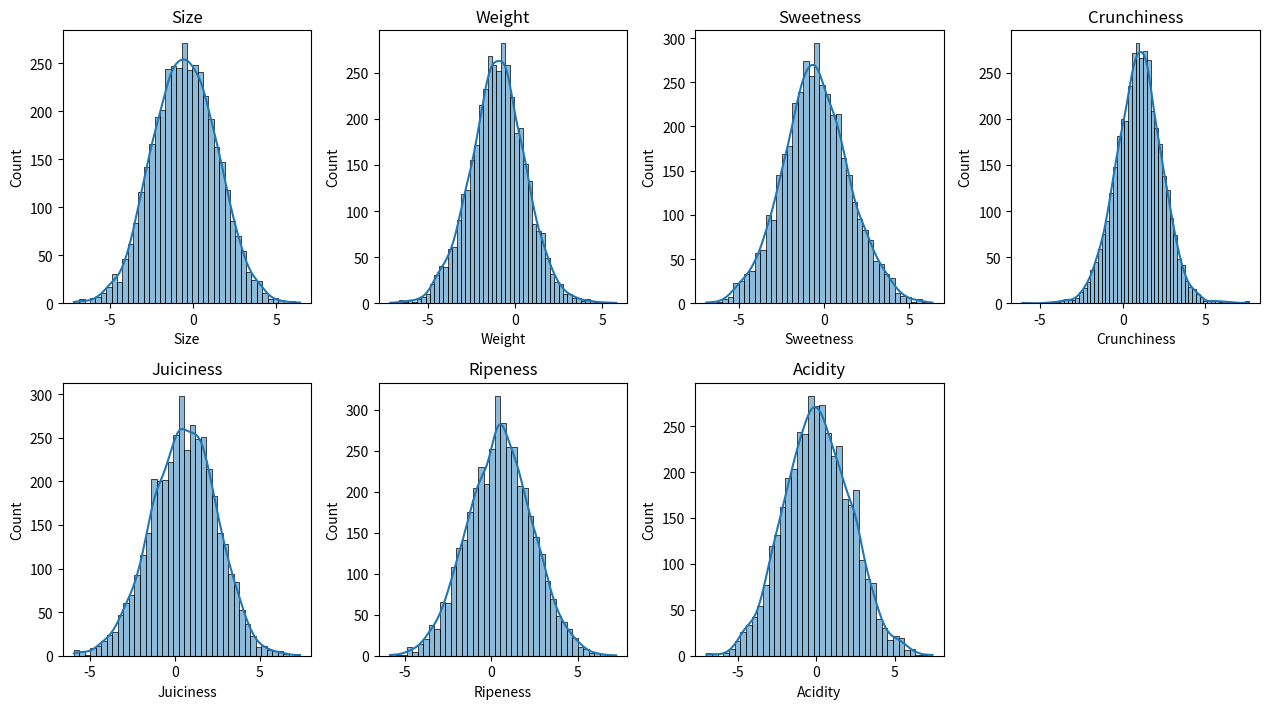

In [14]:

x_cols = [
    "Size",
    "Weight",
    "Sweetness",
    "Crunchiness",
    "Juiciness",
    "Ripeness",
    "Acidity"
]

rows = 2
cols = 4
my_dpi = 100

fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(1280 / my_dpi, 720 / my_dpi),
    dpi=my_dpi
)


axes = axes.flatten()

for i, col in enumerate(x_cols):
    sb.histplot(
        data=origin,
        x=col,
        edgecolor="#000000",
        linewidth=0.5,
        kde=True,
        ax=axes[i]
    )
    axes[i].set_title(col)

# 남는 subplot 숨기기 (8번째 칸)
for j in range(len(x_cols), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()
plt.close()


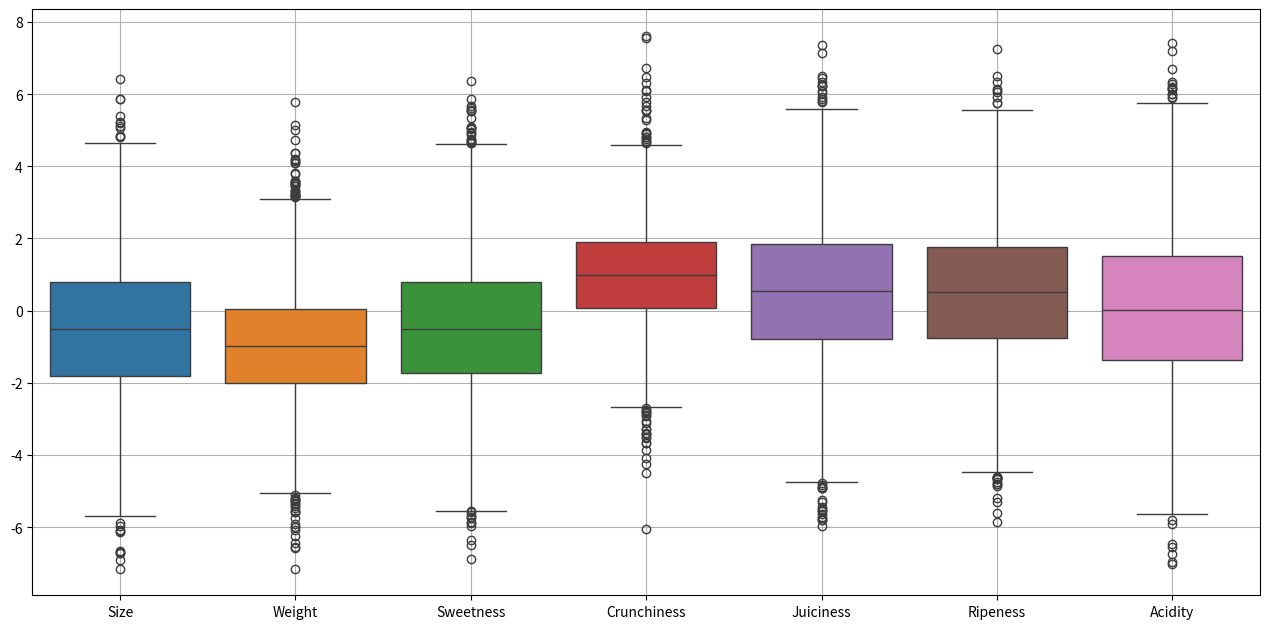

In [15]:
width_px = 1280
height_px = 640
my_dpi = 100

# A_ID, Quality 제외한 데이터 만들기                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
box_data = origin.drop(columns=["A_id", "Quality"])


figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)


sb.boxplot(data=box_data, orient="v", ax=ax)

ax.grid(True)

plt.tight_layout()
plt.show()                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
plt.close()


범위가 가장 넓고 표준편차가 큰 변수는 과일의 산도 수준이다.
왜도를 구했을 때 절댓값이 1보다 작아 왜도가 거의 없고 거의 대칭이라고 본다.
대부분의 이상치는 특정 범위에 집중되어 있으나, Crunchiness는 상대적으로 동떨어진 값을 보여 주고 있습니다.

### 4단계.이변량EDA-"품질에 따라 무엇이 달라질까?"

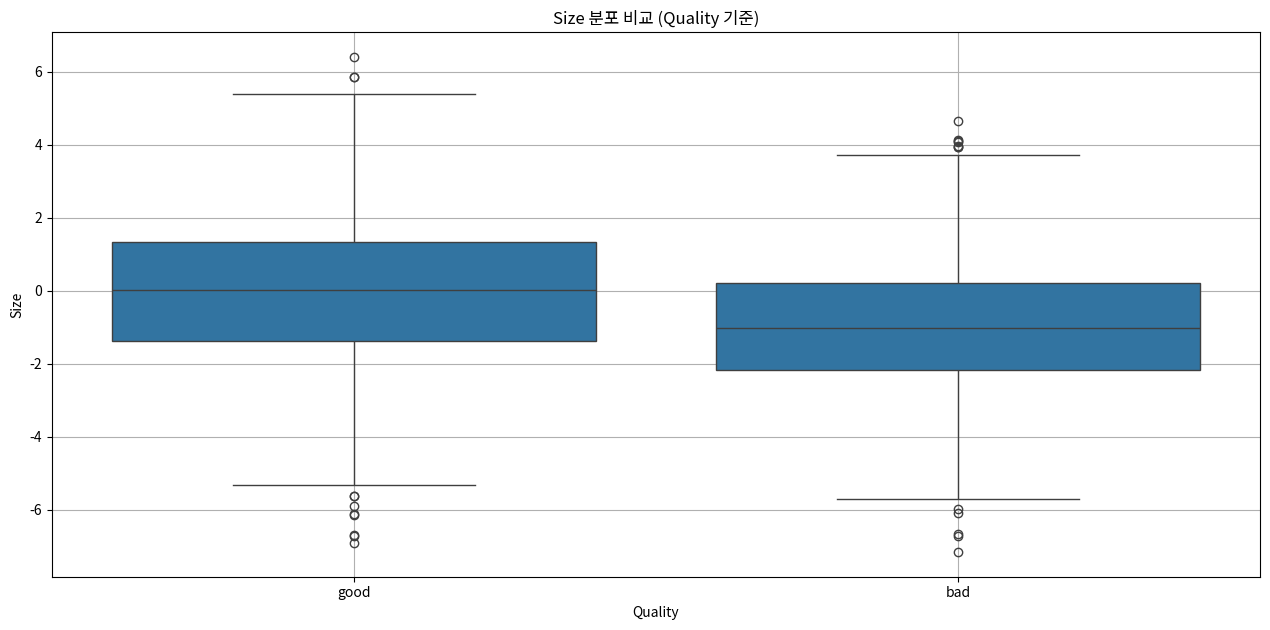

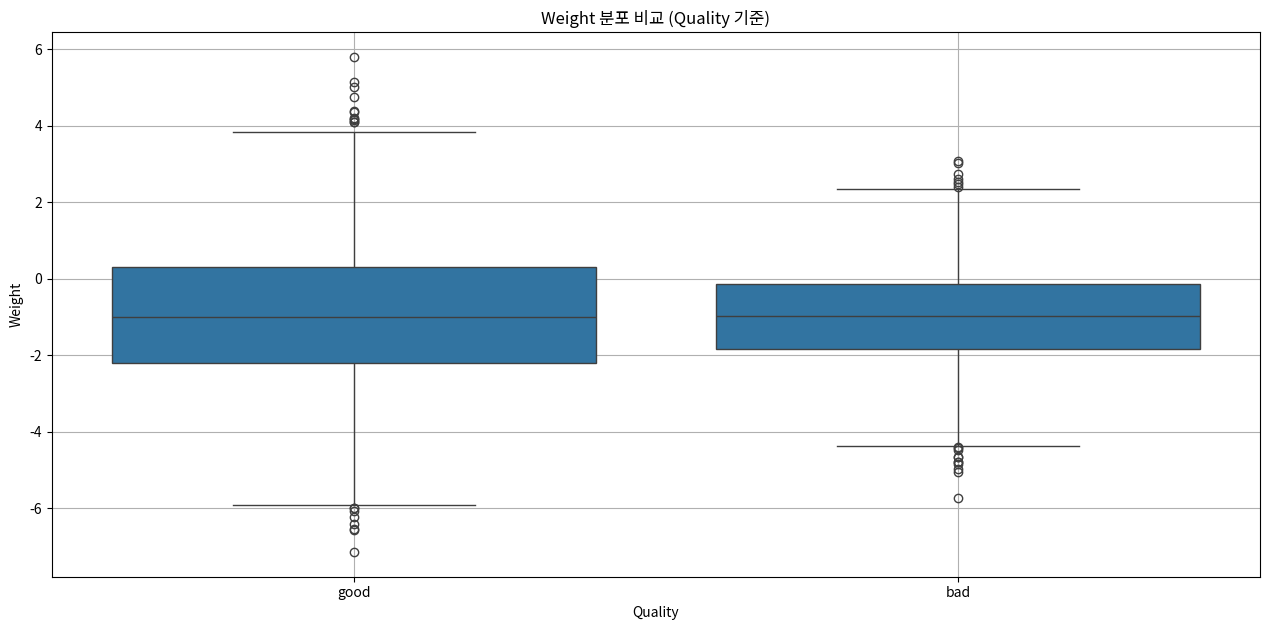

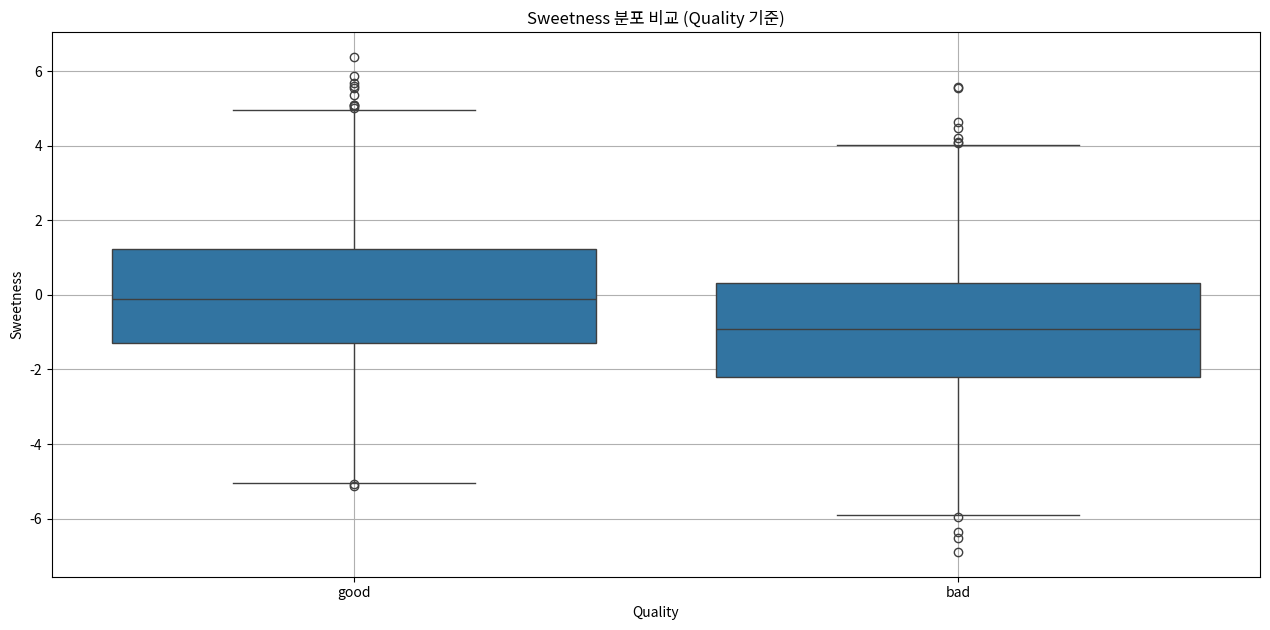

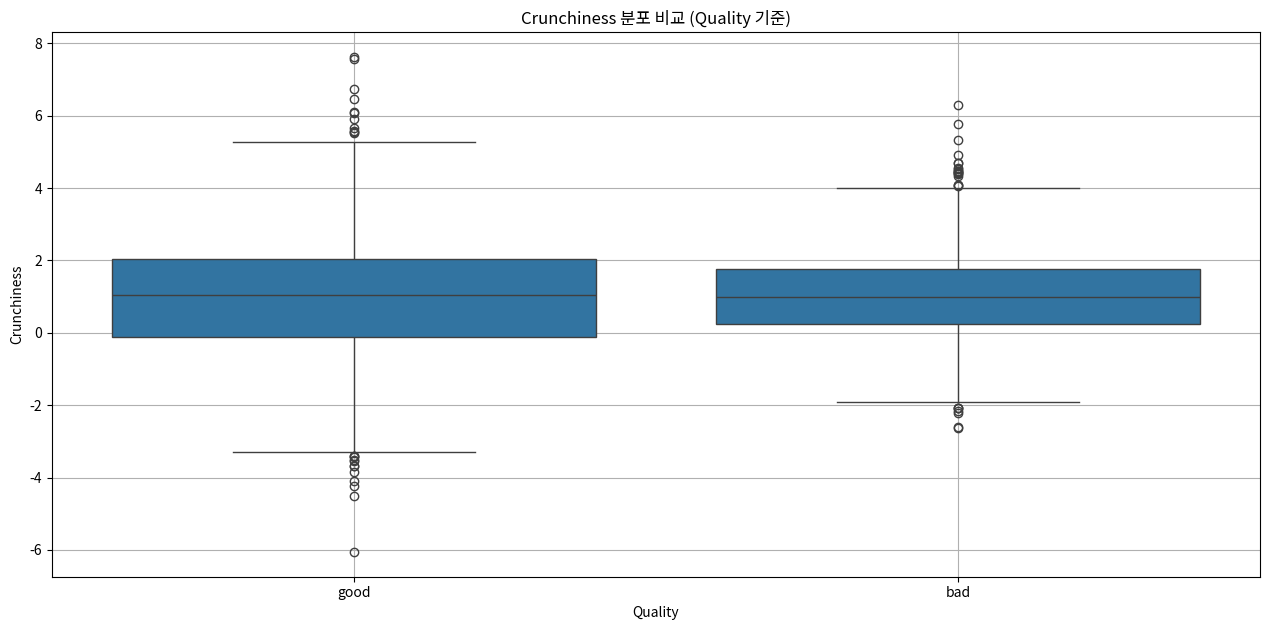

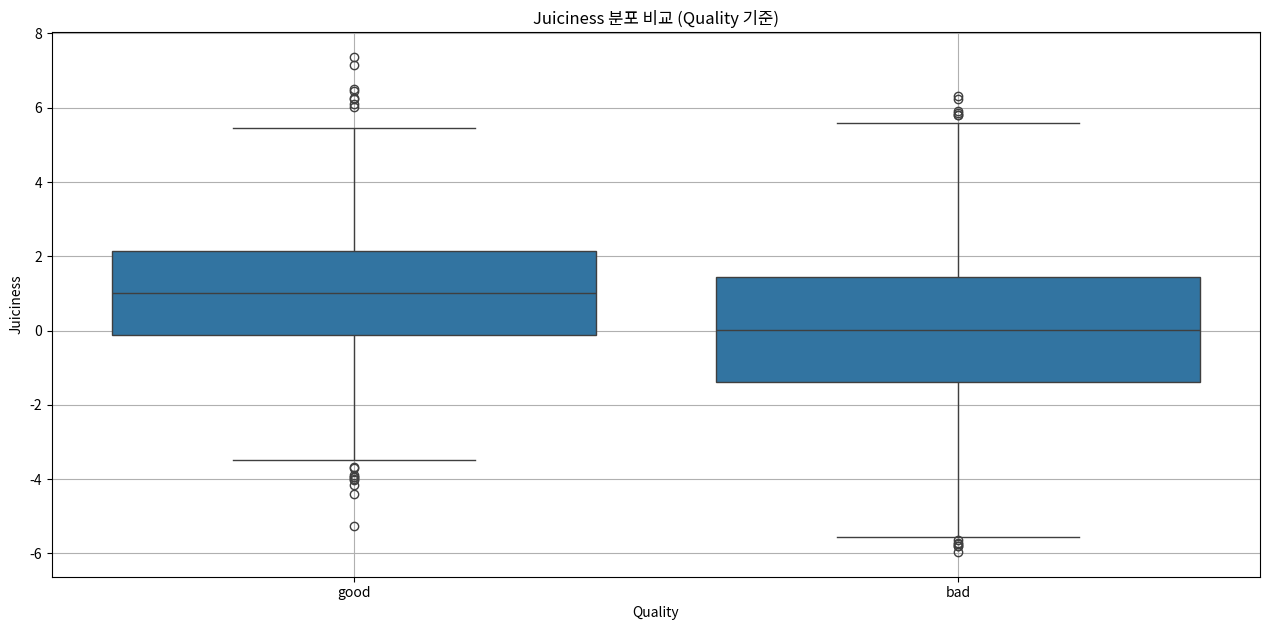

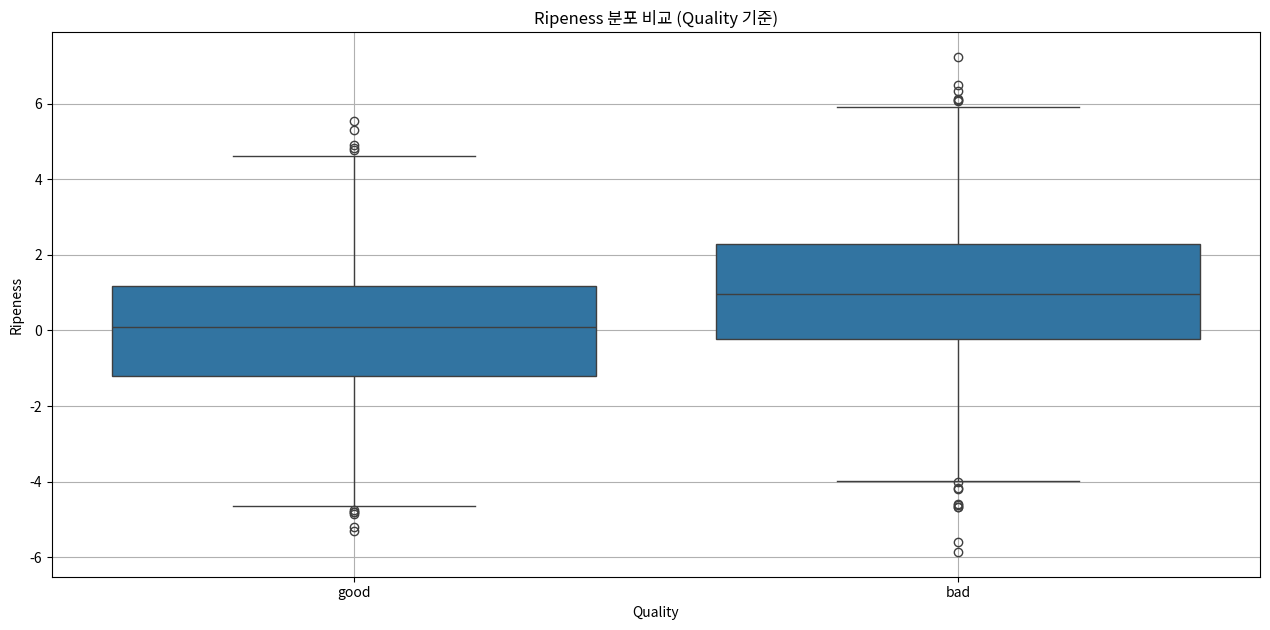

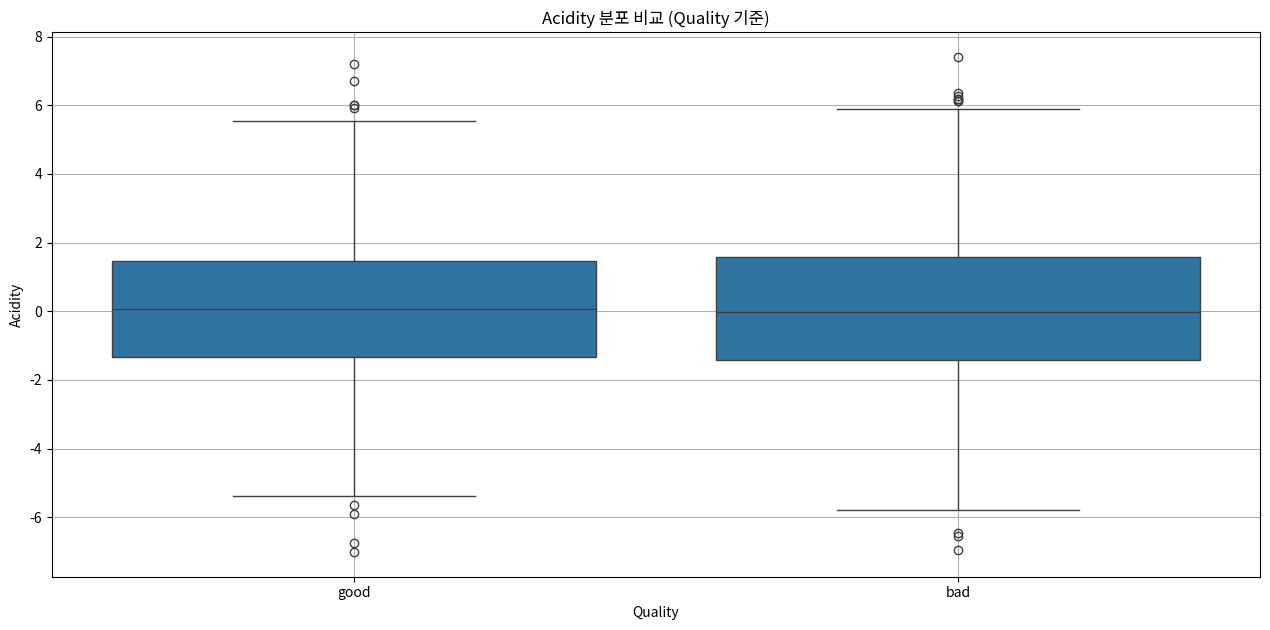

In [16]:
width_px = 1280
height_px = 640
my_dpi = 100
# A_ID, Quality 제외한 숫자형 컬럼만 선택
num_cols = box_data = origin.drop(columns=["A_id"]).select_dtypes(include="number").columns.tolist()

# Quality 컬럼
quality_col = "Quality"

# 변수 하나씩 반복하며 그리기
for col in num_cols:
    figsize = (width_px / my_dpi, height_px / my_dpi)
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)
    
    sb.boxplot(
        data=origin,
        x=quality_col,   # Quality별 그룹
        y=col,           # 연속형 변수
        ax=ax
    )
    
    ax.set_title(f"{col} 분포 비교 (Quality 기준)")
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    plt.close()


2. 박스플롯 분석 결과, Size, Sweetness, Juiciness, Ripeness는 중앙값 차이가 비교적 뚜렷하게 나타난 반면, Weight, Crunchiness, Acidity는 분포가 크게 중첩되어 Quality에 따른 차이가 명확하지 않은 것으로 판단된다.
3.  분류에 도움이 될 것으로 판단되는 변수는 Size, Sweetness, Juiciness, Ripeness이다.

### 5단계.변수 간 관계 탐색-"변수들은 서로 독립적일까?"

In [17]:
df = origin.filter(['Size', 'Sweetness', 'Juiciness', 'Ripeness','Weight', 'Crunchiness', 'Acidity'])
df.head()

,Size,Sweetness,Juiciness,Ripeness,Weight,Crunchiness,Acidity
0,-3.970049,5.346330,1.844900,0.329840,-2.512336,-1.012009,-0.491590
1,-1.195217,3.664059,0.853286,0.867530,-2.839257,1.588232,-0.722809
2,-0.292024,-1.738429,2.838636,-0.038033,-1.351282,-0.342616,2.621636
3,-0.657196,1.324874,3.637970,-3.413761,-2.271627,-0.097875,0.790723
4,1.364217,-0.384658,3.030874,-1.303849,-1.296612,-0.553006,0.501984


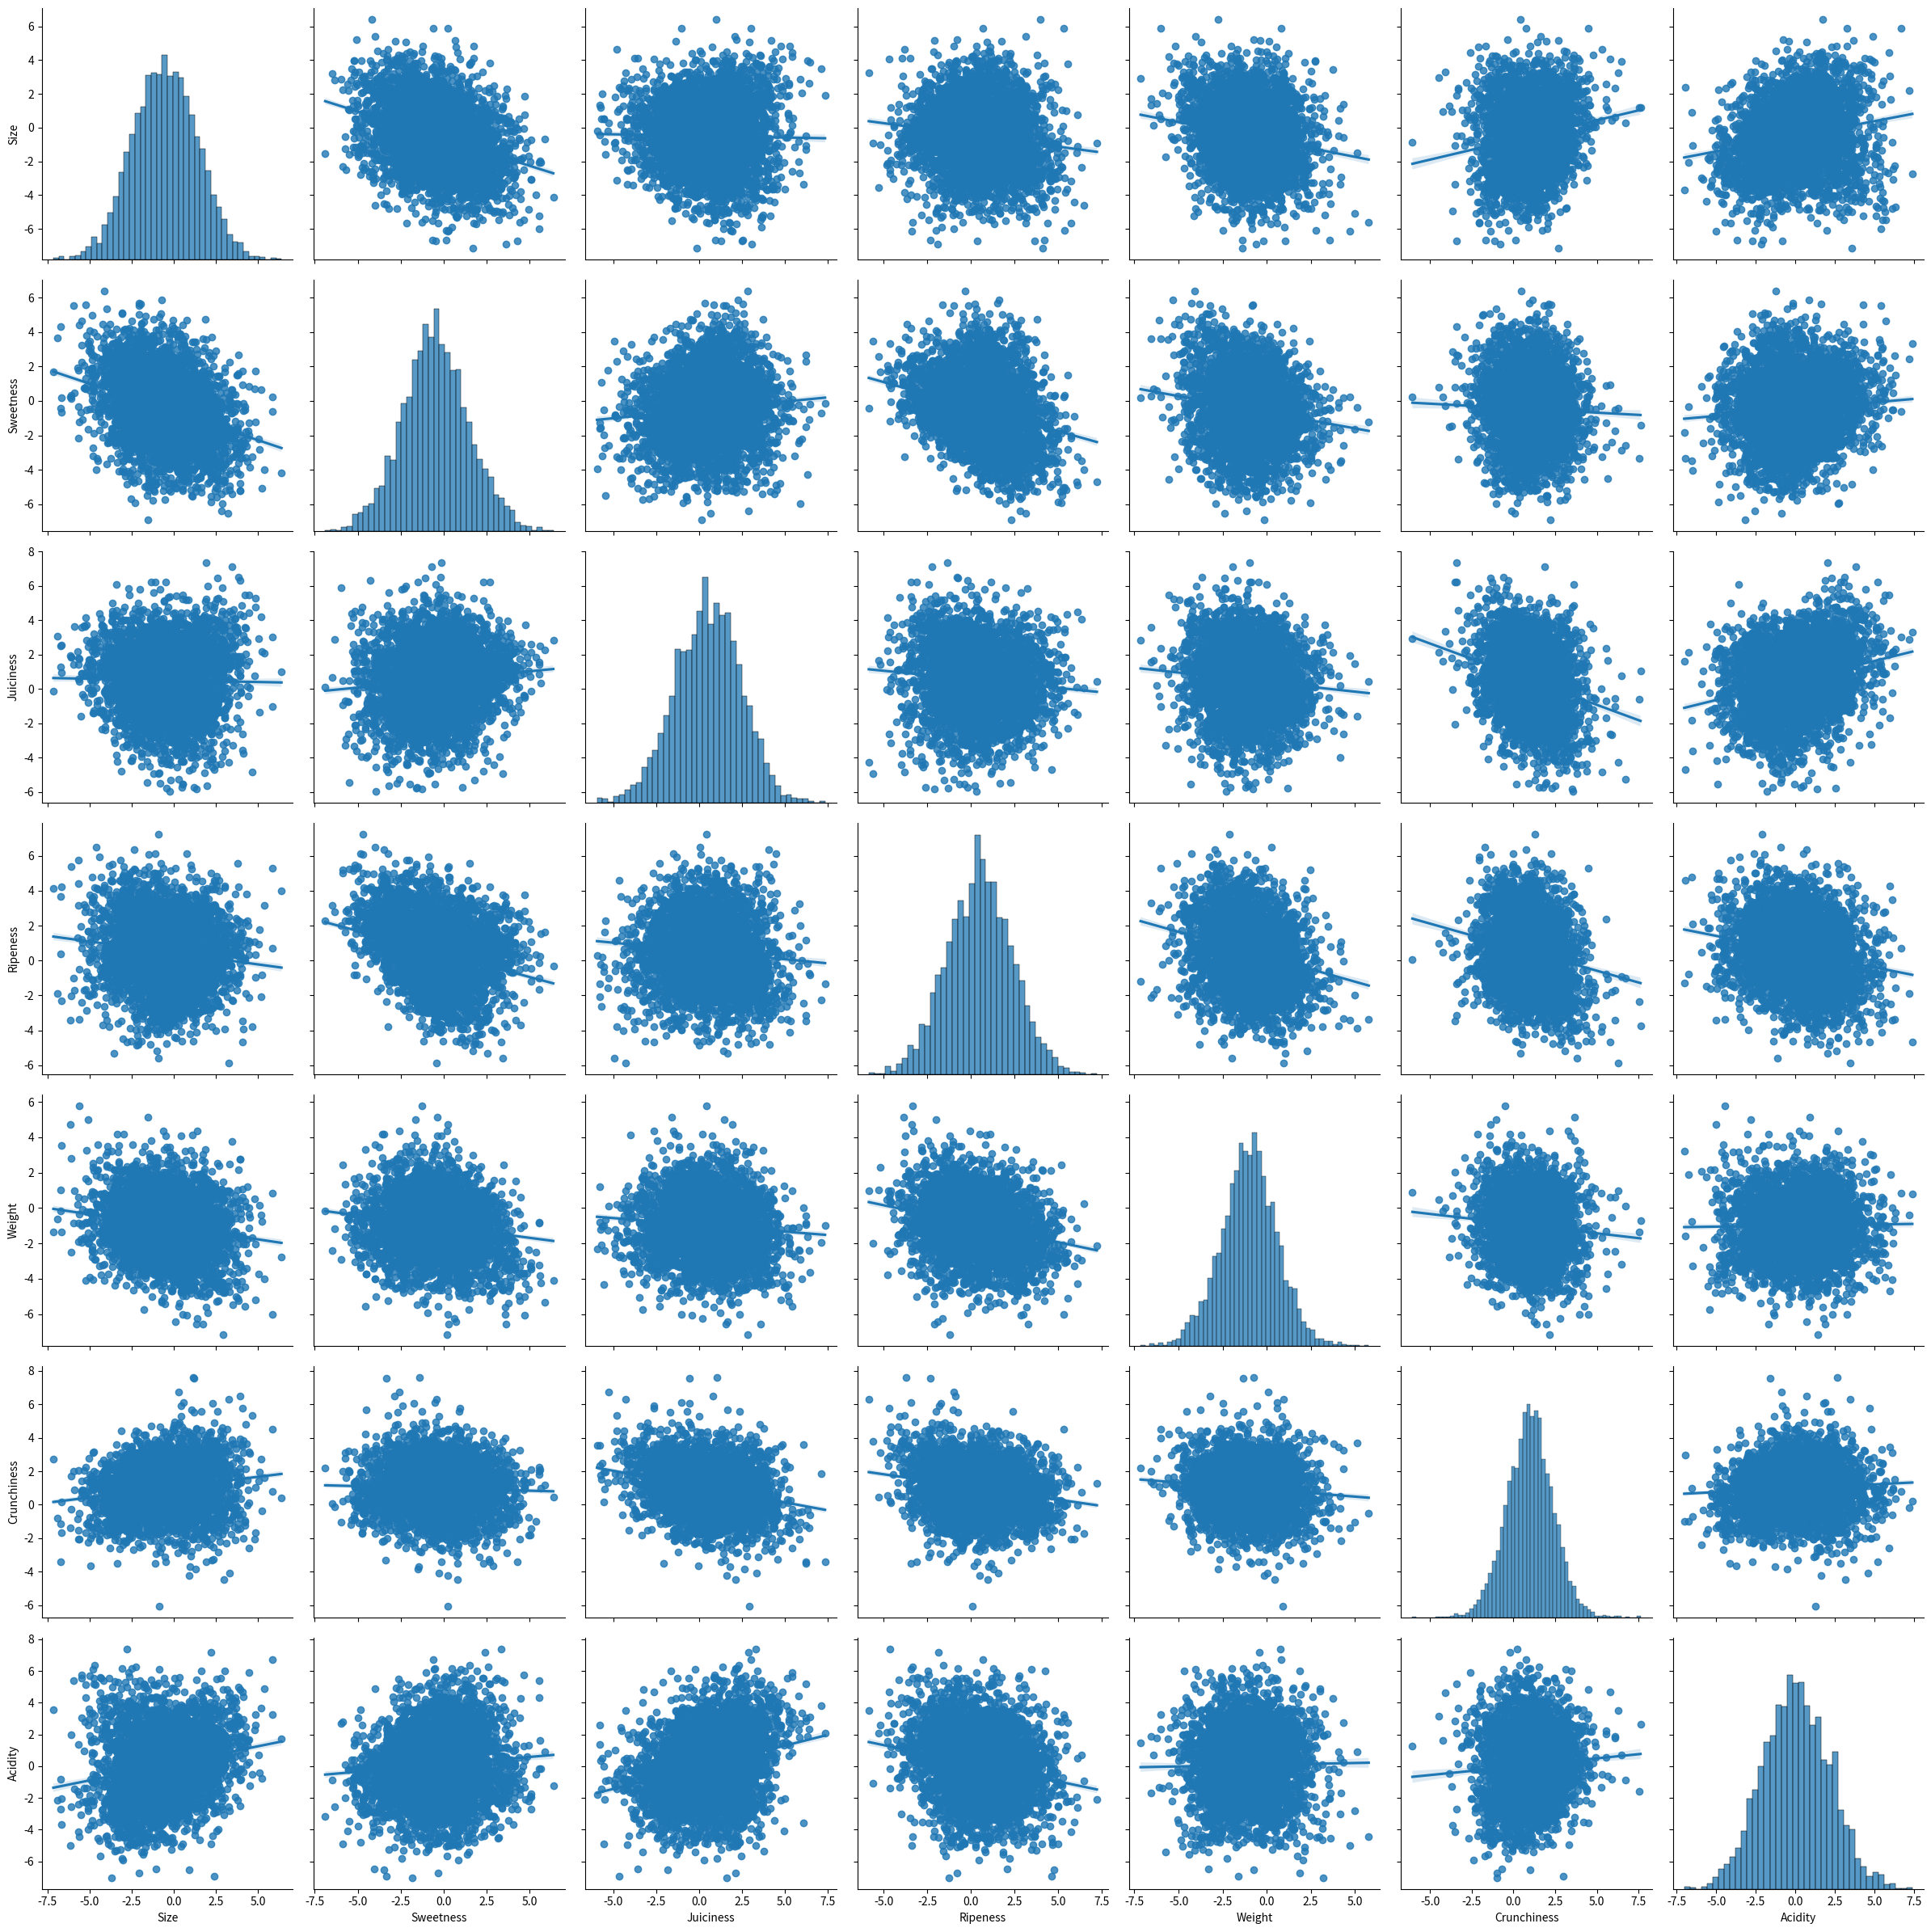

In [18]:
width_px = 2400
height_px = 2400
figsize = (width_px/ my_dpi, height_px/ my_dpi)


g=sb.pairplot(df,kind="reg", diag_kind='hist')
g.fig.set_size_inches(figsize)
g.fig.set_dpi(my_dpi)
plt.tight_layout()
plt.show()
plt.close()

In [19]:
#이상치 요약
skew_outlier = {}
for col in df.columns:
    temp = df[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores)>3))

    data_log = np.log1p(temp-temp.min()+1)
    skew_log = data_log.skew()
    skew_outlier[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z|>3)': outlier_count
        
    }
skew_outlier_df = DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,log_skew,outliers(|z|>3)
Size,-0.002437,-0.829367,10.0
Sweetness,0.083850,-0.741892,10.0
Juiciness,-0.113421,-1.034189,16.0
Ripeness,-0.008764,-0.800417,8.0
Weight,0.003102,-0.826672,21.0
Crunchiness,0.000230,-0.795241,29.0
Acidity,0.055783,-0.774239,8.0


In [20]:
rows = []
for a, b in combinations(df.columns,2):
    x = df[a]
    y = df[b]

#선형성 확인
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power=2, use_f=True)
    linearity_ok = reset.pvalue> 0.05

# 이상치 존재여부(|z|>3 기준)
    a_flag = skew_outlier_df.loc[a, 'outliers(|z|>3)']>0
    b_flag = skew_outlier_df.loc[b, 'outliers(|z|>3)']>0
    outlier_flag = a_flag or b_flag
#상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = 'person'
        corr, pval =pearsonr(x, y)
    
    else:
        chosen = 'spearman'
        corr, pval = spearmanr(x,y)

#유의성 판단(p<=0.05)
    significant = pval <=0.05


# 상관 강도 계산
    abs_r = abs(corr)
    if abs_r>= 0.80:
        strength = "Very strong"
    elif abs_r>= 0.60:
        strength = "Strong"
    elif abs_r>= 0.40:
        strength = "Medium"
    elif abs_r>= 0.20:
        strength = "Weak"
    else:
        strength = "Very weak"

    # 행 추가
    rows.append({
        "var_a":a,
        "var_b":b,
        "linearity": linearity_ok,
        "outlier_flag" :outlier_flag,
        "chosen": chosen, 
        "corr":corr,
        "pval":pval,
        "significant" :significant,
        "strength" :strength
    })

summary_df = DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,Size,Sweetness,True,True,spearman,-0.310476,4.062856e-90,True,Weak
1,Size,Juiciness,False,True,spearman,-0.031881,4.378070e-02,True,Very weak
2,Size,Ripeness,False,True,spearman,-0.154780,7.171387e-23,True,Very weak
3,Size,Weight,True,True,spearman,-0.144268,4.752499e-20,True,Very weak
4,Size,Crunchiness,False,True,spearman,0.171818,7.038392e-28,True,Very weak
5,Size,Acidity,False,True,spearman,0.209998,4.185775e-41,True,Weak
6,Sweetness,Juiciness,True,True,spearman,0.097540,6.338253e-10,True,Very weak
7,Sweetness,Ripeness,False,True,spearman,-0.254604,3.235950e-60,True,Weak
8,Sweetness,Weight,False,True,spearman,-0.119883,2.802006e-14,True,Very weak
9,Sweetness,Crunchiness,False,True,spearman,-0.017346,2.727403e-01,False,Very weak


In [21]:
# 등장하는 모든 변수 목록 추출
vars = sorted(set(summary_df['var_a']).union(summary_df['var_b']))

# 빈 상관행렬 생성(Nan으로 초기화)
corr_matrix = DataFrame(np.nan, index = vars, columns=vars)

# summary_df 내용을 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row['var_a'], row['var_b'], row['corr']
    corr_matrix.loc[a, b] = r
    corr_matrix.loc[b, a] = r #대칭

# 대각선을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)
corr_matrix

,Acidity,Crunchiness,Juiciness,Ripeness,Size,Sweetness,Weight
Acidity,1.000000,0.073556,0.230778,-0.194695,0.209998,0.072026,0.030479
Crunchiness,0.073556,1.000000,-0.236538,-0.183677,0.171818,-0.017346,-0.087117
Juiciness,0.230778,-0.236538,1.000000,-0.124169,-0.031881,0.097540,-0.090611
Ripeness,-0.194695,-0.183677,-0.124169,1.000000,-0.154780,-0.254604,-0.244340
Size,0.209998,0.171818,-0.031881,-0.154780,1.000000,-0.310476,-0.144268
Sweetness,0.072026,-0.017346,0.097540,-0.254604,-0.310476,1.000000,-0.119883
Weight,0.030479,-0.087117,-0.090611,-0.244340,-0.144268,-0.119883,1.000000


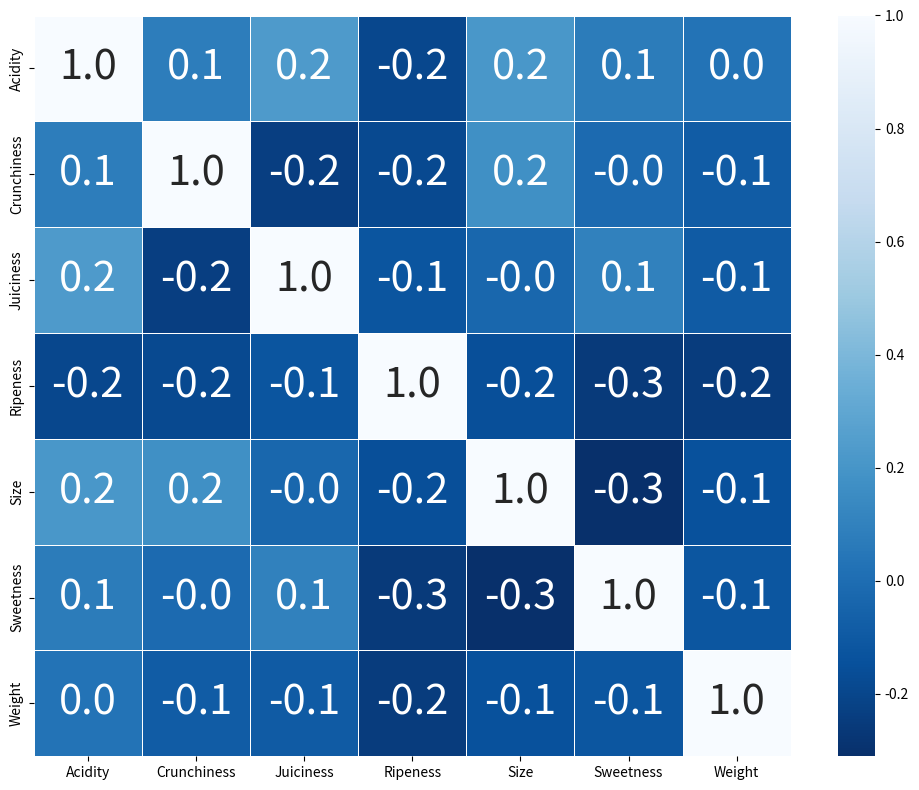

In [22]:
width_px = 1000
height_px = 800
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px/ my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi= my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt = "0.1f", linewidth=0.5, cmap="Blues_r", annot_kws={"size":30})

 
plt.tight_layout()
plt.show()
plt.close()

### 상관 수치에 대한 설명/중복 위험 언급
상관계수 히트맵 결과, 모든 변수 쌍의 상관계수는 0.0에서  -0.3사이로 나타나 전반적으로 약한 상관관계를 보였다.
변수 간 상관계수가 모두 낮아 중복 변수의 가능성은 크지 않으며, 회귀분석 시 다중공선성 발생 위험은 낮은 것으로 판단된다.


### 6단계.EDA를 바탕으로 한 모델 설계-"그려본 결과를 어떻게 모델로 옮길까?"

이 변수는 EDA단계에서  Sweetness와의 관계에서 Size와 Ripeness가 상대적으로 높은 상관계수와 통계적 유의성을 보이는 패턴을 보였기 때문에 품질을 설명하는 데 도움이 될 것으로 판단했다.

EDA 단계에서 Size와 Ripeness는 Sweetness와 유의한 음의 상관 패턴을 보여 품질 변화를 설명하는 데 기여할 것으로 판단하였다.

In [1]:
def logit_report(fit, data, threshold=0.5):
    
    
    #성능평가지표
    yname = fit.model.endog_names
    y_true = data[yname]
    y_pred = fit.predict(fit.model.exog)
    y_pred_fix = (y_pred>=threshold).astype(int)
    
    #혼동행렬
    cm=confusion_matrix(y_true, y_pred_fix)
    tn, fp, fn, tp=cm.ravel()

    acc = accuracy_score(y_true, y_pred_fix)
    pre = precision_score(y_true, y_pred_fix)
    tpr = recall_score(y_true, y_pred_fix)
    fpr = fp/(fp+tn)
    tnr = 1-fpr
    f1 = f1_score(y_true, y_pred_fix)
    ras = roc_auc_score(y_true, y_pred)

    cdf = DataFrame({
        '설명력:[fit.prsquared]'
        '정확도':[acc],
        '정밀도': [pre], 
        '재현율':[tpr],
        '위양성율':[fpr],
        '특이성':[tnr],
        'RAS':[ras],
        'F1':[f1]

    })
    #회귀계수 표 구성(or중심)
    tbl = fit.summary()

    #종속변수명
    yname = fit.model.endog_names
    #독립변수 이름(상수항 제외)
    xnames= [n for n in fit.model.exog_names if n !="const"]

    #독립변수
    x=data[xnames]

    variables = []

    #vif 계산
    vif_dict = {
        col: variance_inflation_factor(x.values, i)
        for i,col in enumerate(x.columns)
    }

    for v in tbl.tables[1].data:
        name = v[0].strip()
        if name not in xnames:
            continue
        beta = float(v[1])
        se = float(v[2])
        z = float(v[3])
        p = float(v[4])

        or_val = np.exp(beta)
        ci_low = np.exp(beta - 1.96 *se)
        ci_high = np.exp(beta +1.96 *se)

        stars = (
            "***" if p<0.001 else
            "**" if p<0.01 else
            "*" if p<0.05 else
            "")
        
        variables.append({
            "종속변수": yname,
            "독립변수": name,
            "B":beta,
            "표준오차":se,
            "z":f"{z:.3f}{stars}",
            "p-value":p,
            "OR":or_val, 
            "CI_lower":ci_low,
            "CI_upper":ci_high,
            "VIF":vif_dict.get(name, np.nan)

        })

    rdf = DataFrame(variables)

    #모델 적합도+예측 성능 지표
    y_true = data[yname]
    y_prob = fit.predict(fit.model.exog)
    y_pred = (y_prob>=threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_fix).ravel()

    acc = accuracy_score(y_true, y_pred_fix)
    pre =precision_score(y_true, y_pred_fix)
    rec = recall_score(y_true, y_pred_fix)
    f1 = f1_score(y_true, y_pred_fix)
    auc = roc_auc_score(y_true, y_prob)

    result_report=(
        f"Pseudo R^2(McFadden) = {fit.prsquared:.3f},"
        f"LLR X^2({int(fit.df_model)}) = {fit.llr:.3f},"
        f"p-value = {fit.llr_pvalue:.4f},"
        f"Auccuracy = {auc:.3f}"
    )
    #모형 보고 문장

    tpl = (
        "%s에 대하여 %s로 예측하는 로지스틱 회귀분석을 실시한 결과,"
        "모형은 통계적으로 %s(X^2(%s)=%.3f, p%s 0.05)하였다."
    )

    model_report = tpl %(
        yname,
        ",".join(xnames),
        "유의" if fit.llr_pvalue <=0.05 else "유의하지 않음",
        int(fit.df_model),
        fit.llr,
        "<="if fit.llr_pvalue<=0.05 else">"
    )
    #변수별 보고 문장

    variable_reports=[]
    s=(
        "%s의 오즈비는 %.3f(p%s 0.05)로,"
        "%s 발생 odds에 %s영향을 미치는 것으로 나타났다."
    )

    for _,row in rdf.iterrows():
        variable_reports.append(
            s%(row["독립변수"],row["OR"],"<="if row["p-value"]<0.05 else ">",row["종속변수"],"유의미한"if row["p-value"]<0.05 else"유의하지 않은"
            )
        )
    return cdf, rdf, result_report, model_report, variable_reports